In [1]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2
from imutils import paths
import os

In [2]:
# set input and output paths
basepath = "/home/rafa/Downloads/github-projects/masknet/data/"
figpath = "plot.png"
modelpath = "masknet.model"

In [3]:
# get all image paths in the base directory
imagepaths = list(paths.list_images(basepath))
data = []
labels = []

# loop over the image paths
for imagepath in imagepaths:
    # get the class label from the filename
    label = imagepath.split(os.path.sep)[-2]

    # load the image, swap color channels, and resize it to 224x224 pixels
    image = cv2.imread(imagepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # append data and labels
    data.append(image)
    labels.append(label)

In [4]:
# transform data and labels to numpy arrays and rescale data to [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into 80% for training and  20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range=15, fill_mode="nearest")

In [5]:
# get resnet and weights
basemodel = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

for layer in basemodel.layers:
    layer.trainable = False

# build the model
x = basemodel.output

x = MaxPool2D(pool_size=(4, 4))(x)
x = Flatten()(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(2, activation="softmax")(x)

model = Model(inputs=basemodel.input, outputs=outputs)

In [6]:
# compile the model
epochs = 25
batch_size = 64

loss = BinaryCrossentropy()
opt = Adam()
model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])

In [7]:
# train the model
H = model.fit(trainAug.flow(trainX, trainY, batch_size=batch_size),
              steps_per_epoch=len(trainX) // batch_size,
              validation_data=(testX, testY),
              validation_steps=len(testX) // batch_size,
              epochs=epochs)

Epoch 1/25
47/47 [==============================] - 21s 450ms/step - loss: 0.2853 - accuracy: 0.9241 - val_loss: 0.0359 - val_accuracy: 0.9870
Epoch 2/25
47/47 [==============================] - 19s 399ms/step - loss: 0.0613 - accuracy: 0.9787 - val_loss: 0.0194 - val_accuracy: 0.9935
Epoch 3/25
47/47 [==============================] - 19s 412ms/step - loss: 0.0567 - accuracy: 0.9797 - val_loss: 0.0236 - val_accuracy: 0.9935
Epoch 4/25
47/47 [==============================] - 19s 404ms/step - loss: 0.0488 - accuracy: 0.9847 - val_loss: 0.0167 - val_accuracy: 0.9961
Epoch 5/25
47/47 [==============================] - 19s 409ms/step - loss: 0.0466 - accuracy: 0.9820 - val_loss: 0.0215 - val_accuracy: 0.9948
Epoch 6/25
47/47 [==============================] - 19s 409ms/step - loss: 0.0407 - accuracy: 0.9867 - val_loss: 0.0113 - val_accuracy: 0.9935
Epoch 7/25
47/47 [==============================] - 19s 407ms/step - loss: 0.0319 - accuracy: 0.9897 - val_loss: 0.0360 - val_accuracy: 0.9857

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[[381   2]
 [  2 382]]
Saving face mask detector model.


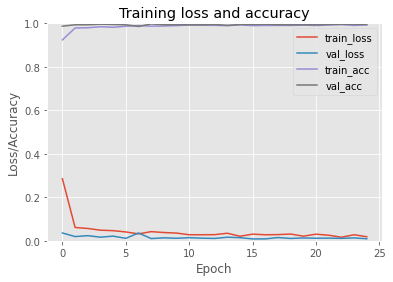

In [8]:
# make predictions on the testing set
predY = model.predict(testX)

# classification report
print(classification_report(testY.argmax(axis=1), predY.argmax(axis=1), target_names=le.classes_))
cm = confusion_matrix(testY.argmax(axis=1), predY.argmax(axis=1))
print(cm)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.title("Training loss and accuracy")
x = np.arange(0, epochs)
plt.plot(x, H.history["loss"], label="train_loss")
plt.plot(x, H.history["val_loss"], label="val_loss")
plt.plot(x, H.history["accuracy"], label="train_acc")
plt.plot(x, H.history["val_accuracy"], label="val_acc")
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(figpath)

# serialize the model to disk
print("Saving face mask detector model.")
model.save(modelpath, save_format="h5")